In [53]:
# IMPORTS

import os
import json
import shutil
import random
import zipfile

import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import files

### FILL KAGGLE CREDENTIALS WITHIN CELL BELOW

In [96]:
!pip install kaggle
api_token = {"username":"USERNAME","key":"API_KEY"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

In [18]:
# HANDLE KAGGLE REFERENCES AND DELIVER DATASET 
! mkdir /tmp/dataset
! kaggle datasets download -d jorgebuenoperez/datacleaningglassesnoglasses -p /tmp/dataset/ --unzip --force

mkdir: cannot create directory ‘/tmp/dataset’: File exists
 97% 453M/465M [00:04<00:00, 99.6MB/s]
100% 465M/465M [00:04<00:00, 106MB/s] 


In [19]:
# CONSTS
DATASET_PATH = '/tmp/dataset/Images/Images'

IMG_SIZE = (160, 160) 
BATCH_SIZE = 32
RANDOM_SEED = tf.random.set_seed(123456)

AUTOTUNE = tf.data.AUTOTUNE

In [20]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

class_names = train_dataset.class_names # for further usage

Found 4920 files belonging to 2 classes.
Using 3444 files for training.
['glasses', 'no_glasses']


In [21]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 1476 files for validation.


In [22]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [97]:
# -- OMMISSIONS
# Number of training batches: 108
# Number of validation batches: 38
# Number of test batches: 9

# print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [37]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [38]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # make sure trainable=True
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [39]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0   

In [40]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset) # check how model performs out of the box 

38/38 [==============================] - 8s 122ms/step - loss: 0.8456 - accuracy: 0.4571


In [42]:
model_fit = model.fit(train_dataset,
                      epochs= initial_epochs,
                      validation_data= validation_dataset)

Epoch 1/10
108/108 [==============================] - 26s 209ms/step - loss: 0.7076 - accuracy: 0.5769 - val_loss: 0.6596 - val_accuracy: 0.6094
Epoch 2/10
108/108 [==============================] - 23s 207ms/step - loss: 0.5540 - accuracy: 0.6986 - val_loss: 0.5636 - val_accuracy: 0.6953
Epoch 3/10
108/108 [==============================] - 23s 206ms/step - loss: 0.4713 - accuracy: 0.7549 - val_loss: 0.4921 - val_accuracy: 0.7466
Epoch 4/10
108/108 [==============================] - 23s 207ms/step - loss: 0.4036 - accuracy: 0.8060 - val_loss: 0.4407 - val_accuracy: 0.7828
Epoch 5/10
108/108 [==============================] - 24s 209ms/step - loss: 0.3509 - accuracy: 0.8406 - val_loss: 0.3969 - val_accuracy: 0.8274
Epoch 6/10
108/108 [==============================] - 24s 209ms/step - loss: 0.3092 - accuracy: 0.8751 - val_loss: 0.3691 - val_accuracy: 0.8468
Epoch 7/10
108/108 [==============================] - 23s 207ms/step - loss: 0.2916 - accuracy: 0.8798 - val_loss: 0.3388 - val_ac

In [43]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)

108/108 [==============================] - 16s 141ms/step - loss: 0.2704 - accuracy: 0.9019


In [44]:
# MAKE MODEL TRAINABLE
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])  

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                           epochs= total_epochs,
                           initial_epoch= model_fit.epoch[-1],
                           validation_data= validation_dataset)  

Number of layers in the base model:  154
Epoch 10/15
108/108 [==============================] - 29s 221ms/step - loss: 0.1165 - accuracy: 0.9477 - val_loss: 0.0287 - val_accuracy: 0.9916
Epoch 11/15
108/108 [==============================] - 24s 213ms/step - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.0182 - val_accuracy: 0.9933
Epoch 12/15
108/108 [==============================] - 24s 214ms/step - loss: 0.0217 - accuracy: 0.9928 - val_loss: 0.0152 - val_accuracy: 0.9941
Epoch 13/15
108/108 [==============================] - 24s 213ms/step - loss: 0.0139 - accuracy: 0.9963 - val_loss: 0.0154 - val_accuracy: 0.9966
Epoch 14/15
108/108 [==============================] - 24s 213ms/step - loss: 0.0081 - accuracy: 0.9969 - val_loss: 0.0129 - val_accuracy: 0.9975
Epoch 15/15
108/108 [==============================] - 24s 215ms/step - loss: 0.0098 - accuracy: 0.9961 - val_loss: 0.0118 - val_accuracy: 0.9975


In [45]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)

38/38 [==============================] - 7s 122ms/step - loss: 0.0118 - accuracy: 0.9975


In [49]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten() # vector of predictions
predictions = tf.nn.sigmoid(predictions) # cast to probs 
predictions = tf.where(predictions < 0.5, 0, 1) # filter, prob < 0.5 --> no_glasses (0 label), else glasses (1 label)

Predictions:
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1]
Labels:
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1]


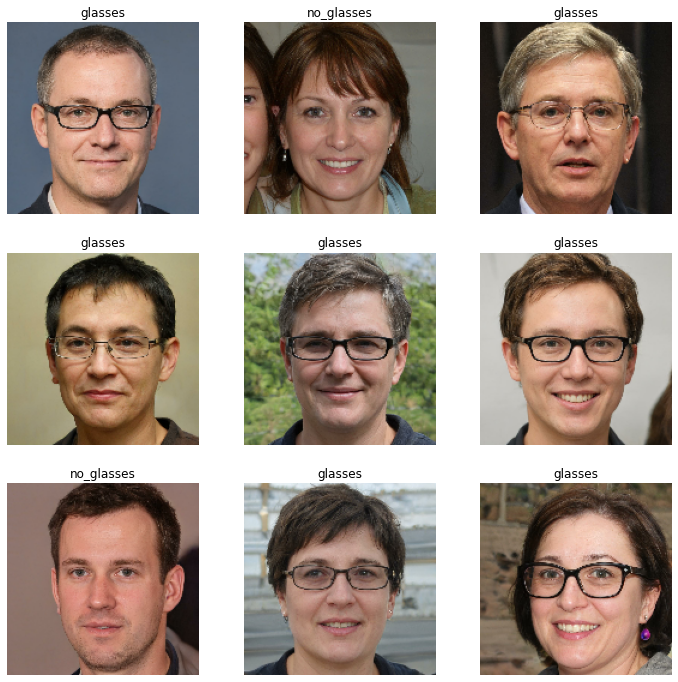

In [50]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [51]:
# save the entire trained model --> further will be Serialized 
model_dir = "/tmp/model"
model.save(model_dir)

INFO:tensorflow:Assets written to: /tmp/model/assets


In [55]:
# ZIP MODEL AND DOWNLOAD TO LOCAL MACHINE
! zip -r /tmp/model.zip /tmp/model
files.download("/tmp/model.zip")

updating: tmp/model/ (stored 0%)
updating: tmp/model/assets/ (stored 0%)
updating: tmp/model/variables/ (stored 0%)
updating: tmp/model/variables/variables.data-00000-of-00001 (deflated 7%)
updating: tmp/model/variables/variables.index (deflated 77%)
updating: tmp/model/saved_model.pb (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# UPLOAD TEST DATA TO COLAB -- OMMISSION
# from google.colab import drive
# drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [83]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

MODEL_PATH = '/tmp/model'
DATASET_PATH = '/content/drive/MyDrive/dataset' # used to validate the model performance within provided test images

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    seed=123456,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

inference_model = keras.models.load_model(MODEL_PATH)
inference_model.evaluate(test_dataset)

Found 40 files belonging to 2 classes.
4/4 [==============================] - 13s 11ms/step - loss: 0.1714 - accuracy: 0.9250


[0.17144954204559326, 0.925000011920929]

In [98]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = inference_model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

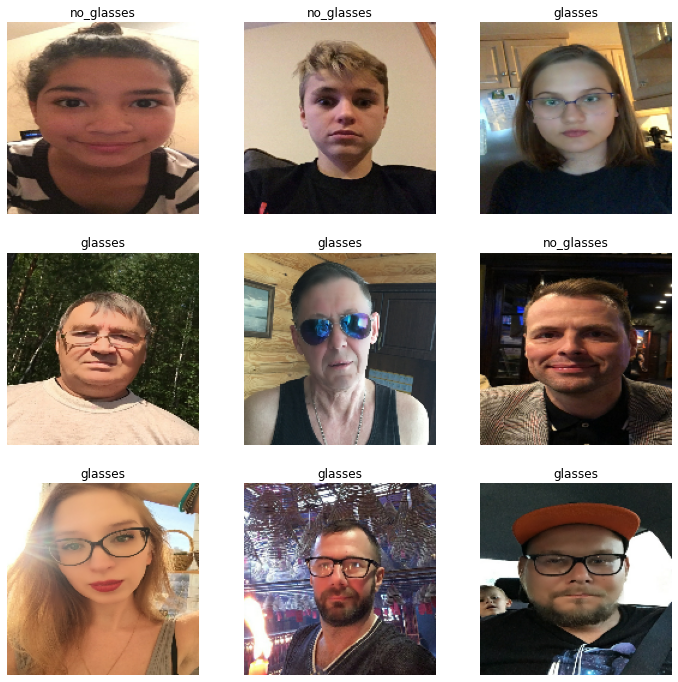

In [99]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")